#Monte Carlo Variance Reduction Methods - Control Variates

In [ ]:
!pip install py_vollib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 5.3 MB/s eta 0:00:00
  Created wheel for py_vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62829 sha256=f3ece1a6134d46cfe5b015eaac35690431dabb2d67f02f25268c4cf39071899d
  Stored in directory: /root/.cache/pip/wheels/84/0c/fc/b68506eda40cccaeb0013be550ba904d253ec90eae2b156052
  Created wheel for py_lets_be_rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24450 sha256=a514d4dddceea94c07bd4e0e7326646077743834ae5c065f646fe49d44182950
  Stored in directory: /root/.cache/pip/wheels/32/d9/4f/360d4b0b9ec7c65583ec7c8e72fd2158c97ad04fbcb932891c
Successfully built py_vollib py_lets_be_rational


In [ ]:
#Import dependencies
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from py_vollib.black_scholes import implied_volatility as iv
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta

/usr/local/lib/python3.10/dist-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [ ]:
# Inital derivative parameters
S = 101.15 #Stock Price
K = 98.01 #Strike Price
vol = 0.0991 #Volatility (%)
r = 0.015 #Risk-free rate (%)
N = 10 #Number of time steps
M = 1000 #Number of simulations

market_value = 3.86 #market value of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365 #time in years
print(T)

0.1643835616438356


In [ ]:
# Precompute constants
N = 10
dt = T/N
nudt = (r-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)

beta1 = -1

#Standard error placeholders
sum_CT = 0
sum_CT2 = 0

#Monte Carlo Method
for i in range(M):
  St  = S
  cv = 0
  for j in range(N):
    #Perfectly Negatively Correlated Assets
    epsilon = np.random.normal()
    deltaST = delta('c', St, K, T-j*dt, r, vol)
    Stn = St*np.exp(nudt + volsdt*epsilon)
    cv = cv + deltaST*(Stn - St*erdt)
    St = Stn

  CT = max(0, St - K) + beta1*cv
  sum_CT = sum_CT + CT
  sum_CT2 = sum_CT2 + CT*CT

#Compute Expectations and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T)/ (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))

Call value is $3.83 with SE +/- 0.011


In [17]:
def delta_calc(r, S, K, T, sigma, type="c"):
  "Calculate delta of an option"
  d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
  try:
    if type == "c":
      delta_calc = stats.norm.cdf(d1, 0, 1)
    elif type == "p":
      delta_calc = -stats.norm.cdf(-d1, 0, 1)
    return delta_calc
  except:
    print("Please confirm option type, either 'c for Call or 'p' for Put")

In [24]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

erdt = np.exp(r*dt)
cv = 0
beta1 = -1

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST ) )
deltaSt = delta_calc(r, ST[:-1].T, K, np.linspace(T,0,N), vol, "c").T
cv = np.cumsum(deltaSt*(ST[1:] - ST[:-1]*erdt), axis=0)


CT = np.maximum(0, ST[-1] - K) + beta1*cv[-1]
# CT = np.maximum(0, ST[-1] - K)
C0 = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))

Call value is $3.85 with SE +/- 0.029


In [20]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)

CTw = np.maximum(0, ST[-1] - K)
C0w = np.exp(-r*T)*np.sum(CTw)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CTw - C0w)**2) / (M-1) )
SEw = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0w,2),np.round(SEw,3)))

Call value is $3.77 with SE +/- 0.107


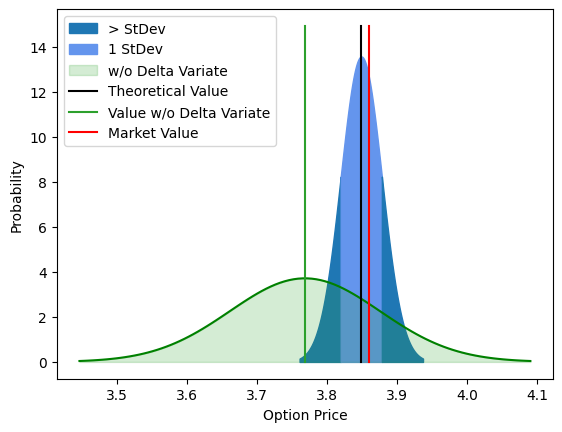

In [25]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
xw = np.linspace(C0w-3*SEw, C0w+3*SEw, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
sw = stats.norm.pdf(xw, C0w, SEw)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Delta Variate')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([C0w,C0w],[0, max(s2)*1.1], color='tab:green',
        label='Value w/o Delta Variate')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()